In [49]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from math import *
import time
import copy
import random

In [100]:
### RESETTING IMAGE RESOLUTION

umpp = 0.91 # um per pixel
time_i = 0 # initial time frame
time_f = 23 # final time frame
path = "Data/nov3_pad3_YFP/monoculture_nov3_pad3_22hr-02_s2t" # file name until timestamp
fc = "Cy3" # fluorescent channel name

nump = 50 # number of pixels to combine when resizing
dx = nump*umpp

dthr = 1 # time interval between frames in hr

# Import images

Phase = []
FC = []

t = time_i+1

im = np.array(Image.open(path+str(t).zfill(2)+".jpg").convert('L'))
Ly = len(im)
Lx = len(im[0])

Ly_new = int(Ly/nump)
Lx_new = int(Lx/nump)

size = Lx_new, Ly_new

def resolve_down(im, factor):
    Lx, Ly = im.size
    
    LR_off = Lx%factor
    L_off = int(LR_off/2)
    R_off = Lx-LR_off+L_off
    TB_off = Ly%factor
    T_off = int(TB_off/2)
    B_off = Ly-TB_off+T_off
    
    im1 = np.array(im.crop((L_off, T_off, R_off, B_off)))
    
    new = []
    for a in im1:
        b = a.reshape(-1, factor).mean(axis=1)
        new.append(b)
    new = np.array(new).T
    neww = []
    for a in new:
        b = a.reshape(-1, factor).mean(axis=1)
        neww.append(b)
    newww = np.array(neww).T
    
    return newww

while t<time_f:
    imp = Image.open(path+str(t).zfill(2)+"_Phase.jpg").convert('L')
    imp_resized = resolve_down(imp, nump)
    #imp_resized = np.array(imp.resize(size, Image.ANTIALIAS)).astype(np.float32)
    imf = Image.open(path+str(t).zfill(2)+"_{}.jpg".format(fc)).convert('L')
    imf_resized = resolve_down(imf, nump)
    #imf_resized = np.array(imf.resize(size, Image.ANTIALIAS)).astype(np.float32)
    
    Phase.append(imp_resized)
    FC.append(imf_resized)
    t+=1
    
Phase = np.array(Phase)
FC = np.array(FC)

In [101]:
## STARTING MODEL PARAMETERS and step size bounds

# Cell
mu = 0.35/3600        # max growth rate of strain 1 (in 1/sec)
step_mu = 0.1/3600

Qhf = 70              # cell density for half pressure (in pixel intensity)
step_Qhf = 50

Phf = 70              # cell density for half acceptance (in pixel intensity)
step_Phf = 50

Y = 160               # biomass yield (in pixel intensity per unit S0)
step_Y = 50

# Glucose
log10Ks = -2          # rate of nutrient consumption by Monod kinetics (in unit log10S0)
step_log10Ks = 1 

# Diffusion
DC = 1200             # spreading coefficient of cells (in um^2)
step_DC = 100

DS = 200              # diffusion coefficient of glucose (in um^2/sec)
step_DS = 100

# Initial condition
S0 = 1                # glucose concentration in feed medium

Parameters = [mu, Qhf, Phf, Y, log10Ks, DC, DS]
steps = [step_mu, step_Qhf, step_Phf, step_Y, step_log10Ks, step_DC, step_DS]
idx_ex = [4] # index of parameter that need not be non-negative

In [102]:
## GRADIENT FUNCTIONS

def grad_vec_field(series, t, Lx, Ly, dx):

    xr = np.arange(0, Ly*dx, dx)
    yr = np.arange(0, Lx*dx, dx)

    # Create grid corresponding to xr and yr arrays
    xx, yy = np.meshgrid (xr, yr, indexing = 'ij')

    zz1 = series[t+1]
    gradx1, grady1 = np.gradient(zz1, dx, dx)

    zz0 = series[t]
    gradx0, grady0 = np.gradient (zz0, dx, dx)
    
    return(xx, yy, gradx1-gradx0, grady1-grady0)

def plot_vec_field(series, t, Lx, Ly, dx):
    
    xx, yy, Dx, Dy = grad_vec_field(series, t, Lx, Ly, dx)

    fig = plt.figure(constrained_layout=True, figsize=(15,8))
    axs = fig.subplot_mosaic([['Left', 'TopRight'],['Left', 'BottomRight']],
                          gridspec_kw={'width_ratios':[2, 1]})
    
    TB = axs['TopRight'].imshow(-Dx, cmap='coolwarm')
    axs['TopRight'].set_title('Y component of ascent rate')
    fig.colorbar(TB, ax=axs['TopRight'])
    
    LR = axs['BottomRight'].imshow(Dy, cmap='coolwarm')
    axs['BottomRight'].set_title('X component of ascent rate')
    fig.colorbar(LR, ax=axs['BottomRight'])
    
    skip = (slice(None, None, 2), slice(None, None, 2))

    axs['Left'].quiver(yy[skip], np.flip(xx)[skip], Dy[skip] , -Dx[skip],
                      color='black', headwidth=5, scale=1, headlength=5)

## MODEL FUNCTIONS

def nbr_sum(M):
    """Get the discrete Laplacian of matrix M"""
    L = np.roll(M, (0,-1), (0,1)) # right neighbor
    L += np.roll(M, (0,+1), (0,1)) # left neighbor
    L += np.roll(M, (-1,0), (0,1)) # top neighbor
    L += np.roll(M, (+1,0), (0,1)) # bottom neighbor
    
    return L

def discrete_laplacian(M):
    """Get the discrete Laplacian of matrix M"""
    L = -4*M
    L += nbr_sum(M)
    
    return L

def divide(M1,M2):
    """To divide two numpy arrays M1/M2 element-wise and avoide division by zero"""
    f = np.divide(M1, M2, out=np.zeros_like(M1), where=M2!=0)
    return f

def update(C, S, Parameters):
    
    mu, Qhf, Phf, Y, log10Ks, DC, DS = tuple(Parameters)
    
    Q = C/(Qhf+C)
    P = Phf/(Phf+C)
    Ks = 10**log10Ks
    
    Sdiff = res*DS*discrete_laplacian(S) - dt*mu*C*divide(S,Y*(Ks+S))
    Cdiff = dt*mu*(1-Q)*C*S/(Ks+S) + res*DC*mu*(P*nbr_sum(C*Q*S/(Ks+S)) - Q*C*S*nbr_sum(P)/(Ks+S))
    
    C += Cdiff
    S += Sdiff
    # Remove negative values
    S[S < 0] = 0 
    
    # Reflecting boundaries
    
    C[0,:], S[0,:] = C[1,:], S[1,:]          # top
    C[-1,:], S[-1,:] = C[-2,:], S[-2,:] # bottom
    C[:,0], S[:,0] = C[:,1], S[:,1]         # left
    C[:,-1], S[:,-1] = C[:,-2], S[:,-2]  # right
                            
    return C, S

def get_error(Phase, FC, Parameters):

    # Initialize
    C = copy.deepcopy(FC[0])
    C -= threshold
    C[C<0]=0
    S = np.ones((Ly_new,Lx_new))

    # Simulate

    update_every = dthr*3600 # number of time steps after which data is stored
    C_time = []
    S_time = []

    start = time.time()

    for tt in range(T):
        if tt%update_every == 0:
            C_time.append(C.copy())
            S_time.append(S.copy())
        C, S = update(C, S, Parameters)

    stop = time.time()

    error = 0

    t = time_i

    while t<time_f-2:
        xx, yy, DxO, DyO = grad_vec_field(Phase, t, Lx_new, Ly_new, dx)
        xx, yy, DxP, DyP = grad_vec_field(C_time, t, Lx_new, Ly_new, dx)
    
        err_arr = (C_time[t]-Phase[t])**2 + lam*((DxP-DxO)**2 + (DyP-DyO)**2)
        error += np.sum(err_arr)
        t+=1

    return(sqrt(error))

def cap_par(Parameters, idx_ex):
    i = 0
    for par in Parameters:
        if i in idx_ex:
            continue
        else:
            Parameters[i] = max(0, par)
        i+=1
    return(Parameters)

In [103]:
### SIMULATED ANNEALING PARAMETERS

# coefficient of error formula
lam = 10**6

# Number of iterations of simated annealing
an_steps = 1000

# Initial temperature
maxTemp = 5*10**4

### SIMULATION PARAMETERS
# threshold
threshold = 1 # number to subtract from all pixels of the image used as initial condition for simulation

# Time Resolution in sec
dt = 1
# Time steps
T = int((time_f-1)*dthr*3600)

res = dt/dx**2 

print("Simulation time is", dt*T, "seconds \n dt =", dt, "seconds")
print("dt / dx^2 = ", res)

Simulation time is 79200 seconds 
 dt = 1 seconds
dt / dx^2 =  0.0004830334500664171


In [ ]:
iter = 0
Parameters = np.array(Parameters)
errors = []
Temps = []
Parameters_dat = []

while iter < an_steps:
    
    Temp = maxTemp/(iter+1)
    
    current_error = get_error(Phase, FC, Parameters)
    
    new_Parameters = Parameters + np.random.uniform(-1,1, len(Parameters))*np.array(steps)
    new_Parameters = cap_par(new_Parameters, idx_ex)
    
    new_error = get_error(Phase, FC, new_Parameters)
    
    Derror = new_error - current_error
    
    if Derror <= 0:
        Parameters = new_Parameters
    else:
        metropolis = 2.7183**(-Derror/Temp)
        rand = random.uniform(0,1)
        if rand < metropolis:
            Parameters = new_Parameters
    
    errors.append(current_error)
    Temps.append(Temp)
    Parameters_dat.append(Parameters)
    
    iter +=1
    print(iter)

In [ ]:
Parameters

In [ ]:
plt.plot(errors)

In [ ]:
plt.plot(Temps)

In [ ]:
# Initialize
C = copy.deepcopy(FC[0])
C -= threshold
C[C<0]=0
S = np.ones((Ly_new,Lx_new))

# Simulate

update_every = dthr*3600 # number of time steps after which data is stored
C_time = []
S_time = []

start = time.time()

for tt in range(T):
    if tt%update_every == 0:
        C_time.append(C.copy())
        S_time.append(S.copy())
    C, S = update(C, S, Parameters)

stop = time.time()

In [ ]:
for i in C_time:
    plt.plot(i[60][15:40])

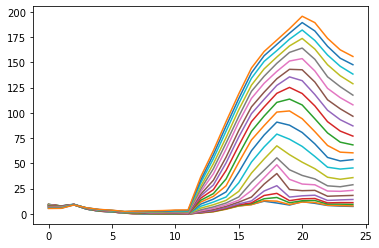

In [83]:
for i in Phase:
    plt.plot(i[60][15:40])

In [87]:
get_error(Phase, FC, Parameters)

(57980204.42536698, 47.27147053856498)

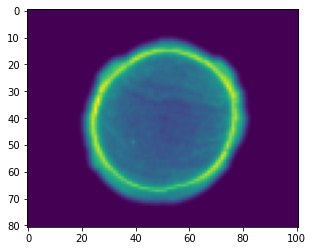

In [98]:
plt.imshow(C_time[-1])

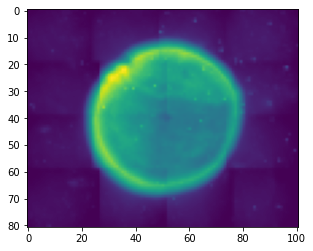

In [99]:
plt.imshow(Phase[-1])